In [212]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## GAIA
This is a simple implementation of GAIA (the one from the paper), showing how the network is trained. It is dependent upon having downloaded the CELEBA dataset. Which is available in create_dataset.ipynb. The dataset downloaded is not quite CELEBA-HQ, to get the full CELEBA-HQ dataset, see [ProGAN repo](https://github.com/tkarras/progressive_growing_of_gans). The model takes at least a few days to train on a TitanXP. Below I've linked to a pretrained model. 

### Load necessary packages

In [214]:
# visualization
import IPython.display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# computation
import numpy as np
import tensorflow as tf
import tensorflow.contrib as tf_contrib
import pickle

# local scripts
import data_iterator as it
import network as nt

### Choose GPU

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import pandas as pd

### Load dataset

In [4]:
dataset_dims = 128 # what size data are we going to use?
dims = [dataset_dims, dataset_dims, 3] # first dimension of input data
batch_size = 8 # what's in the batch
p_valid = .05 # what percent of the data should be set aside for validation
lr_max = 1e-4 # the learning rate for the network

In [5]:
# parameters for the dataset we're using
hdf5_path = ''.join(['../GAIA/data/faces_hq_dataset_'+str(dataset_dims)+'.h5']) # where is our HDF5 file
hdf5_labels = ['images']# ['images', 'label_input'] # what datasets to pass through the iterator

In [6]:
iterator = it.HDF5_iterator(files = [hdf5_path], data_names = ['images'], batch_size = batch_size, p_valid=p_valid)
num_examples = len(iterator.train_idxs)
iterator.new_epoch()

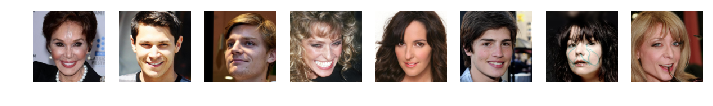

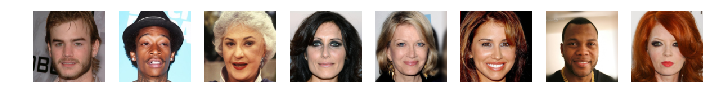

In [62]:
zoom = 1.5
for a in range(2):
    example_data = iterator.iterate()[0]/255.
    fig, ax = plt.subplots(nrows=1, ncols =batch_size, figsize = (batch_size*zoom,zoom))
    for i,j in enumerate(example_data[:batch_size]): ax[i].imshow(j.reshape(dims)); ax[i].axis('off')
    plt.show()

### Create Model

In [8]:
model = nt.GAIA(dims, batch_size, network_type='GAIA', gpus=[0],
               adam_eps = 1.0e-8, activation_fn=tf.nn.elu,
               n_res = 4, ch=64, n_sample=2, style_dim=512,n_hidden=512,
              )

Creating Generator...
...Creating encoder in generator...
... Creating interpolations...
...Creating decoder in generator...
Creating Discriminator...
...Creating encoder in discriminator...
...Creating decoder in discriminator...
Network Initialized


### Train model (or skip this step and load the model below)

In [9]:
# what information to save from the model
to_return = (
    [model.train_D,"train_D"],
    [model.train_G,"train_G"],
    [model.L_d,"L_d"],
    [model.L_g,"L_g"],
    [model.x_fake_recon_loss,"x_fake_recon_loss"],
    [model.x_real_recon_loss,"x_real_recon_loss"],
    [model.lr_D,"lr_D"],
    [model.lr_G,"lr_G"],
    [model.m_global,"m_global"],
    [model.discrim_proportion_fake,"discrim_proportion_fake"],
    [model.discrim_proportion_real,"discrim_proportion_real"],
    [model.x_fake_from_sample_recon_loss,"x_fake_from_sample_recon_loss"],
    [model.x_fake_from_real_recon_loss,"x_fake_from_real_recon_loss"],
    [model.gen_proportion_sample,"gen_proportion_sample"],
    )
return_list = list(np.array(to_return).T[0])
return_names = list(np.array(to_return).T[1])
results = pd.DataFrame(columns = return_names[2:]) # a dataframe of results of the network

In [10]:
interp_midpoints = [(example_data[:int(batch_size/2)][i]*.5 +example_data[int(batch_size/2):][i]*.5).reshape(dims) for i in range(int(batch_size/2))] +  \
                           [(example_data[:int(batch_size/2)][::-1][i]*.5 +example_data[int(batch_size/2):][i]*.5).reshape(dims) for i in range(int(batch_size/2))]

In [11]:
def plot_figure(model, example_data, batch_size, interp_midpoints):
    """ Plots reconstructions in GAIA
    """
    canvas = np.zeros((dims[0]*7, dims[1]*batch_size, dims[2]))
    D_X, G_X, D_G_X, G_interp, D_G_interp = model.sess.run(
    (model.x_real_recon, model.x_fake_from_real,model.x_fake_from_real_recon, model.x_fake_from_sample, model.x_fake_from_sample_recon),
     {
        model.x_input: example_data,
        model.midpoint_div_1:np.repeat(0.5, int(model.batch_size/2)),
        model.midpoint_div_2:np.repeat(0.5, int(model.batch_size/2)),
     }
    )
    fig,ax = plt.subplots(figsize=(batch_size*zoom,7*zoom))
    ax.axis('off')
    for di, (data,title) in enumerate([
        [example_data, '$X$'],[D_X, '$D(X)$'],[D_G_X, '$D(G(X))$'],[G_X, '$G(X)$'],[G_interp, '$G(Z_{interp})$'],
        [D_G_interp, '$D(G(Z_{interp}))$'],[interp_midpoints, '$X_{interp}$'],]):
        canvas[di*dims[0]:(di+1)*dims[0], :,:] = np.concatenate([i.reshape(dims) for i in data[:batch_size]], axis = 1)
        ax.text(0,di*dims[0], title,
                    verticalalignment='top',
                    horizontalalignment='left',
                    color='white',
                    style='italic',
                    fontsize=15,
                bbox={'color':'black', 'alpha':0.75,'pad':3})
    ax.imshow(canvas)
    plt.show()

In [20]:
total_batch =  num_examples//batch_size # how many batches per epoch
num_epochs = 1000 # how many epochs to train for
try:
    for epoch in tqdm(np.arange(num_epochs)):
        iterator.new_epoch(); rows = []
        for i in tqdm(range(total_batch), leave=False):
            rows.append(model.sess.run(return_list,{
                            model.x_input: iterator.iterate()[0]/255.,
                            model.lr_max : lr_max,
                            model.lr_sigma_slope : 20., # the slope of the sigmoid for the learning rate
                            model.latent_loss_weights : lr_max/2.,
                        }
                        ))
        results.loc[len(results)] = np.mean([np.array(rows)[:,2:]], axis=1).astype('float32')[0]
        IPython.display.clear_output()
        plot_figure(model, example_data, batch_size, interp_midpoints)
except KeyboardInterrupt:
    print('interrupted')

interrupted


### Load trained model
- First run the download_weights notebook

In [19]:
model.load_network('models/downloaded_weights/new_manual/model.tfmod')

INFO:tensorflow:Restoring parameters from models/downloaded_weights/new_manual/model.tfmod
Network Loaded


### Interpolations between points

In [58]:
def encode_x(x, zs_shape, zc_shape, batch_size):
    nex =np.ceil(len(x)/batch_size).astype('int')
    face_z = [np.zeros([nex*batch_size] + list(zs_shape)[1:]), np.zeros([nex*batch_size] + list(zc_shape)[1:])]
    face_x = np.zeros([nex*batch_size] + list(np.shape(x_recon)[1:]))
    face_x[:len(x)] = x
    for batch in np.arange(nex):
        cur_batch = face_x[int(batch*batch_size):int((batch+1)*batch_size)]
        zs_out, zc_out = model.sess.run([model.z_gen_style_net_real, model.z_gen_content_net_real],{model.x_input: cur_batch})
        face_z[0][batch*batch_size:(batch+1)*batch_size] = zs_out
        face_z[1][batch*batch_size:(batch+1)*batch_size] = zc_out
    z_final = [face_z[0][:len(x)], face_z[1][:len(x)]]
    return z_final


def decode_z(z):
    nex =np.ceil(len(z[0])/batch_size).astype('int')
    face_x = np.zeros([nex*batch_size] + list(np.shape(x_recon)[1:]))
    face_z = [np.zeros([nex*batch_size] + list(np.shape(z[0])[1:])), np.zeros([nex*batch_size] + list(np.shape(z[1])[1:]))]
    face_z[0][:len(z[0])] = z[0]
    face_z[1][:len(z[1])] = z[1]
    for batch in np.arange(nex):
        cur_batch = [face_z[0][int(batch*batch_size):int((batch+1)*batch_size)], face_z[1][int(batch*batch_size):int((batch+1)*batch_size)]]
        x_out = model.sess.run(model.x_fake_from_real,{model.z_gen_style_net_real: cur_batch[0], model.z_gen_content_net_real: cur_batch[1]})
        face_x[batch*batch_size:(batch+1)*batch_size] = x_out
    faces_x_final = face_x[:len(z[0])]
    return faces_x_final

In [661]:
example_data = example_data[0]/255.
x_fake, x_fake_recon, x_gen, x_gen_recon, generator_z_style, generator_z_content ,x_recon  = model.sess.run((model.x_fake_from_real,
                                                           model.x_fake_from_real_recon, 
                                                           model.x_fake_from_sample, 
                                                           model.x_fake_from_sample_recon,
                                                           model.z_gen_style_net_real,                             
                                                          model.z_gen_content_net_real, 
                                                          model.x_real_recon,
                                                          ),
                                                               
                         {model.x_input: example_data})

In [662]:
np.shape(example_data[0])

(49152,)

In [663]:
import copy

(-0.5, 1535.5, 511.5, -0.5)

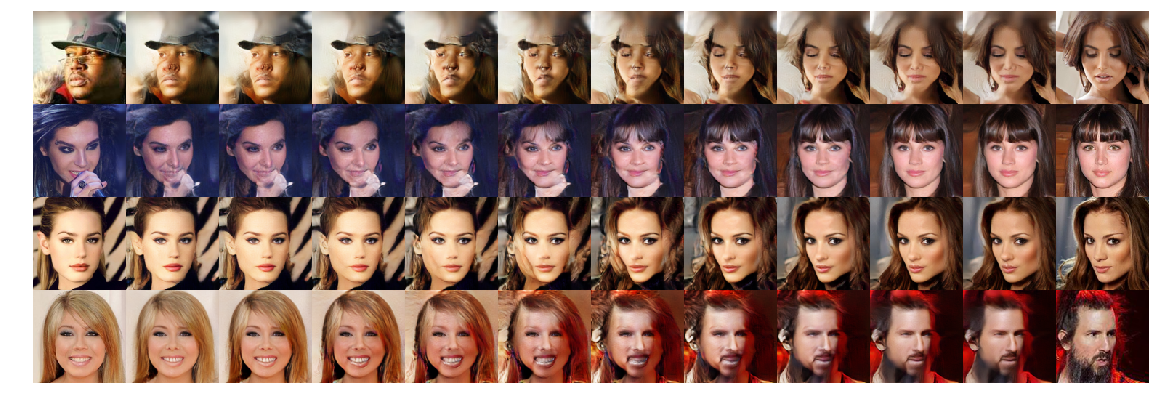

In [664]:
n_cols = 10
n_rows = 4
imsize =zoom= 2
nex = n_cols*n_rows
extent=1
zs,zc = encode_x(example_data, zs_shape=np.shape(generator_z_style), zc_shape=np.shape(generator_z_content), batch_size=batch_size)
ns = copy.deepcopy(dims)
ns[1]*=n_cols
pcts = np.linspace(0,1, n_cols)
fig, ax = plt.subplots(figsize=(zoom*n_cols,zoom*n_rows))

canvas = np.zeros((dims[0]*n_rows,128*(n_cols+2),3))
for ei in np.arange(4):
    zc_new =np.concatenate([[generator_z_content[ei]*pct + generator_z_content[ei+4]*(1-pct)] for pct in pcts])
    zs_new = np.concatenate([[generator_z_style[ei]*pct + generator_z_style[ei+4]*(1-pct)] for pct in pcts])
    encoded_examples = decode_z([zs_new,zc_new]) 
    canvas[ei*128:(ei+1)*128, 128:128*(n_cols+1), :] = np.concatenate([i.reshape(dims) for i in encoded_examples], axis = 1)
    
canvas[:,-128:,:] = np.concatenate([i.reshape(dims) for i in example_data[:n_rows]], axis = 0)
canvas[:,:128:,:] = np.concatenate([i.reshape(dims) for i in example_data[n_rows:]], axis = 0)


plt.imshow(canvas, interpolation=None)  
ax.axis('off')

### Adding attribute vectors

In [1115]:
# prepare iterator
big_batch = 8*32
hdf5_path = 'data/CELEBA-128-Annot-hq.h5' # where is our HDF5 file
iterator = it.HDF5_iterator(files = [hdf5_path], data_names = ['images', 'attrs'], batch_size = big_batch, p_valid=p_valid)
iterator.new_epoch()

['images', 'attrs']


In [1116]:
with h5py.File(hdf5_path, 'r') as hf:
    print(np.shape(hf['attrs']))
    print(list(hf.keys()))

(49968, 40)
['attrs', 'attrs_head', 'images', 'rot_lr_ud']


In [1117]:
# This is the header for the features
attrs_head = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
              'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
              'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
              'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
              'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
              'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
              'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
              'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie',
              'Young']

['Attractive' 'Blond_Hair' 'Heavy_Makeup' 'No_Beard' 'Pointy_Nose'
 'Wavy_Hair' 'Wearing_Lipstick' 'Wearing_Necklace']


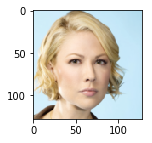

In [1118]:
# see example face/features
example_data = iterator.iterate()
ex_zs, ex_zc = encode_x(example_data[0]/255., zs_shape=np.shape(generator_z_style),
          zc_shape=np.shape(generator_z_content),
          batch_size=batch_size)

ex =0
fig = plt.figure(figsize=(2,2))
plt.imshow(example_data[0][ex].reshape(dims))
print(np.array(attrs_head)[:-2][example_data[1][ex][:-2] ==1])

#### Get latent representations from dataset

In [788]:
n_batches = len(iterator.train_idxs)//big_batch
n_batches = 100
numex = big_batch*(n_batches)
all_attr = np.zeros((numex, np.shape(example_data[1])[1]))
all_zs = np.zeros([numex]+list(np.shape(ex_zs)[1:]))
all_zc = np.zeros([numex]+list(np.shape(ex_zc)[1:]))
for bi in tqdm(np.arange(n_batches)):
    img, attr = iterator.iterate()
    zs, zc= encode_x(img/255., zs_shape=np.shape(generator_z_style),
          zc_shape=np.shape(generator_z_content),
          batch_size=batch_size)
    all_attr[bi*big_batch:(bi+1)*big_batch,:] = attr
    all_zs[bi*big_batch:(bi+1)*big_batch,:, :,:] = zs
    all_zc[bi*big_batch:(bi+1)*big_batch,:] = zc
    
    

In [797]:
np.shape(all_zc), np.shape(all_zs), np.shape(all_attr)

((25600, 512), (25600, 1, 1, 512), (25600, 42))

#### Get latent vectors for each feature

In [798]:
from statsmodels.api import OLS

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [863]:
np.shape(np.hstack([1*(all_attr[:,:-2]==1),all_attr[:,-2:]]))

(25600, 42)

In [865]:
data_labels = pd.DataFrame(np.hstack([1*(all_attr[:,:-2]==1),all_attr[:,-2:]]), columns = attrs_head+['lr','ud'] )
data_labels['bias'] = 1
data_labels[:3]

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,lr,ud,bias
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.594424,0.672154,1
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.616046,0.731325,1
2,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.111510,0.736591,1


In [866]:
model_z = OLS(np.hstack([all_zc, np.squeeze(all_zs)]), data_labels)
result_z = model_z.fit()

In [867]:
result_z.params[:3]

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
5_o_Clock_Shadow,56.590095,4.940752,42.967589,9.073291,-3.229552,2.243555,30.184168,12.594304,-25.060400,20.389077,...,0.634317,0.963316,1.023322,-0.285370,-1.140894,-0.185584,-0.114083,2.274524,0.609493,1.309315
Arched_Eyebrows,24.667943,12.632723,-9.566961,21.744944,-16.821498,-9.016389,-1.409405,9.720382,-6.031314,-35.065363,...,0.164810,-0.096143,-0.290188,-0.546054,-0.168828,-0.197064,-0.052075,0.421711,0.031736,-0.010991
Attractive,67.718048,-6.983880,7.252143,10.115989,11.978610,10.069839,10.857380,-13.741224,-21.183669,20.412484,...,1.000281,-0.428024,-0.363375,-0.821464,-0.201885,-0.011942,-0.100398,1.676494,0.366102,0.474786


In [873]:
full_vecs_zc_model = result_z.params.values[:-1,:512]
full_vecs_zs_model = result_z.params.values[:-1,512:].reshape((len(full_vecs_zc_model), 1, 1, np.shape(all_zs)[-1]))

In [874]:
np.shape(full_vecs_zc_model), np.shape(full_vecs_zs_model)

((42, 512), (42, 1, 1, 512))

#### Plot vector

In [875]:
constructed_vecs_model = decode_z([full_vecs_zs_model, full_vecs_zc_model])

In [872]:
np.shape(constructed_vecs_model)

(40, 49152)

(640, 1024, 3)


(-0.5, 1023.5, 639.5, -0.5)

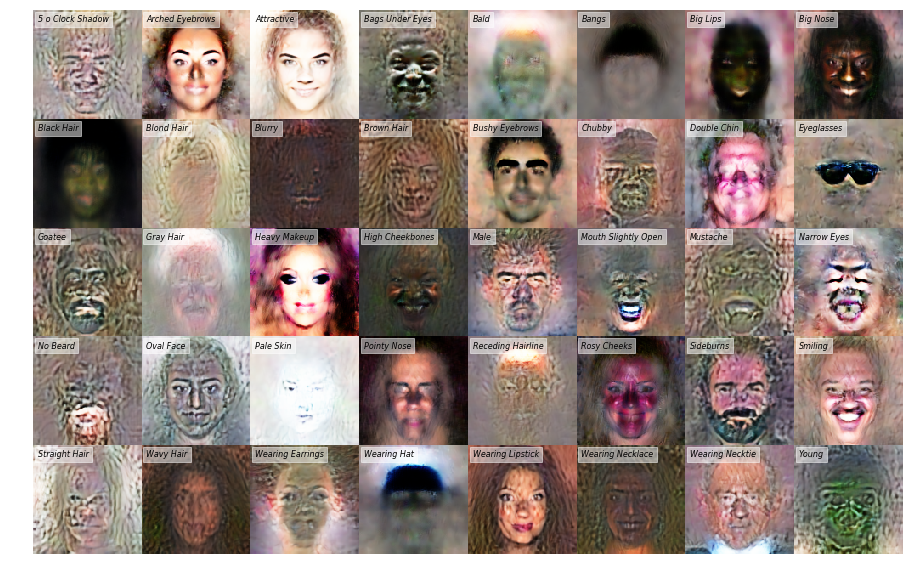

In [881]:
zoom = 2
nrow = 5
ncol = 8
fig, ax = plt.subplots(figsize=(zoom*ncol,zoom*nrow))
canvas = np.zeros((dims[0]*nrow,128*ncol,3))
print(np.shape(canvas))
for atri,attr in enumerate(constructed_vecs_model[:40]):
    cs = [(atri//ncol),(atri//ncol +1), (atri%ncol),(atri%ncol+1)]
    canvas[cs[0]*dims[0]:cs[1]*dims[0], cs[2]*dims[1]:cs[3]*dims[1],:] = np.squeeze(constructed_vecs_model)[atri].reshape(dims)
    
    ax.text(cs[2]*dims[0]+nrow,cs[0]*dims[1]+nrow, ' '.join(data_labels.columns[atri].split('_')),
                verticalalignment='top',
                horizontalalignment='left',
                color='black',
                style='italic',
                fontsize=8,
            bbox={'color':'white', 'alpha':0.5,'pad':3})
plt.imshow(canvas)  
ax.axis('off')

#### Add vectors to example data

In [848]:
example_data = iterator.iterate()
ex_zs, ex_zc = encode_x(example_data[0]/255., zs_shape=np.shape(generator_z_style),
          zc_shape=np.shape(generator_z_content),
          batch_size=batch_size)

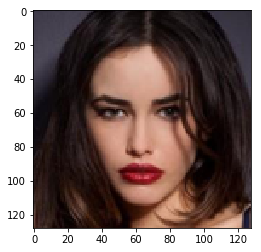

In [853]:
plt.imshow(example_data[0][0].reshape(dims))

In [943]:
test_person = example_data[0]

(640, 1024, 3)


(-0.5, 1023.5, 639.5, -0.5)

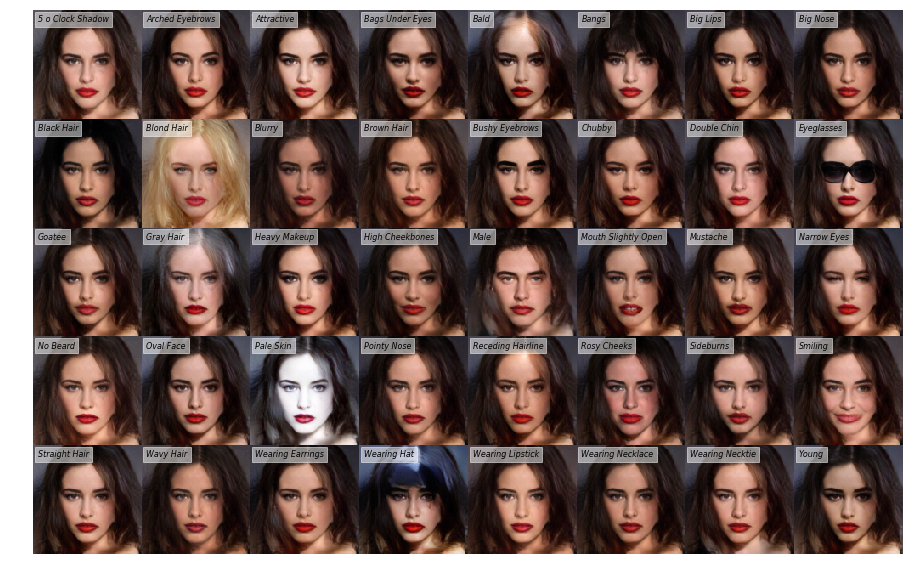

In [856]:
extent = 3 # how much to apply the manipulation
zoom = 2
zs,zc = encode_x(example_data[0]/255., zs_shape=np.shape(generator_z_style),
          zc_shape=np.shape(generator_z_content),
          batch_size=batch_size)
zc = np.array([ex_zc[0] + i*extent for i in full_vecs_zc_model])
zs = np.array([ex_zs[0] + i*extent for i in full_vecs_zs_model])
encoded_examples = decode_z([zs,zc]) 

fig, ax = plt.subplots(figsize=(zoom*8,zoom*5))
canvas = np.zeros((dims[0]*5,128*8,3))
print(np.shape(canvas))
for atri,attr in enumerate(encoded_examples):
    cs = [(atri//8),(atri//8 +1), (atri%8),(atri%8+1)]
    canvas[cs[0]*dims[0]:cs[1]*dims[0], cs[2]*dims[1]:cs[3]*dims[1],:] = encoded_examples[atri].reshape(dims)
    
    ax.text(cs[2]*dims[0]+5,cs[0]*dims[1]+5, ' '.join(data_labels.columns[atri].split('_')),
                verticalalignment='top',
                horizontalalignment='left',
                color='black',
                style='italic',
                fontsize=8,
            bbox={'color':'white', 'alpha':0.5,'pad':3})
plt.imshow(canvas)  
ax.axis('off')

#### Manipulate face direction

In [1108]:
iterator = it.HDF5_iterator(files = [hdf5_path], data_names = ['images', 'attrs'], batch_size = batch_size, p_valid=p_valid)
iterator.new_epoch()

['images', 'attrs']


In [1109]:
with open('celebs.pickle', 'rb') as handle:
    celebs = pickle.load(handle)

In [1110]:
celebs_zs, celebs_zc = encode_x(np.array(list(celebs.values())), zs_shape=np.shape(generator_z_style),
          zc_shape=np.shape(generator_z_content),
          batch_size=batch_size)

In [1111]:
example_data= iterator.iterate()
ex_zs, ex_zc = encode_x(example_data[0]/255., zs_shape=np.shape(generator_z_style),
          zc_shape=np.shape(generator_z_content),
          batch_size=batch_size)

In [1112]:
np.shape(full_vecs_zc)

(43, 512)

In [1114]:
n_samp =90
nrows=4
ncols=6
canvas = np.zeros((dims[0]*nrows,128*ncols,3))
anim_frames = []
anim_fig = plt.figure(figsize=(zoom*ncols,zoom*nrows))
ax = plt.Axes(anim_fig, [0., 0., 1., 1.])
anim_fig.add_axes(ax)
for theta in tqdm(np.linspace(0, 2*np.pi, n_samp)):
    zc_new =[celebs_zc[person] + full_vecs_zc_model[-2]*(np.cos(theta)*15-3) + full_vecs_zc_model[-1]*np.sin(theta)*0 for person in range(len(celebs_zc))]
    zs_new = [celebs_zs[person] + full_vecs_zs_model[-2]*(np.cos(theta)*15-3) + full_vecs_zs_model[-1]*np.sin(theta)*0 for person in range(len(celebs_zs))]
    encoded_examples = decode_z([zs_new,zc_new])
    for col in range(ncols):
        canvas[:,(col*dims[1]):(col+1)*dims[1], :] = encoded_examples[(nrows*col):(1+col)*nrows].reshape(dims[0]*nrows, dims[1], dims[2])
    anim_frames.append([ax.imshow(canvas, interpolation=None)])
    ax.axis('off')
plt.close(anim_fig)
start_time = time.time()
Writer = FFMpegWriter
writer = Writer(fps=45, bitrate=-1)
print("--- %s seconds to prepare writer ---" % (time.time() - start_time))
anim = animation.ArtistAnimation(anim_fig, anim_frames, interval=200, blit=True, repeat_delay=0)
print("--- %s seconds to create animation ---" % (time.time() - start_time))
anim.save('/mnt/cube/tsainbur/Projects/github_repos/timsainburg_dot_com/timsainburg.com/content/assets/video/rotation.mp4', writer=writer)
print("--- %s seconds to save ---" % (time.time() - start_time))


--- 0.0001983642578125 seconds to prepare writer ---
--- 2.8073463439941406 seconds to create animation ---
--- 11.031875371932983 seconds to save ---


<video controls style="text-align:center;width:100%;max-width:900px" autoplay muted playsinline loop src="images/rotation.mp4"/> 